In [117]:
import torch
import sys
sys.path.insert(0,'..')
from syndatagenerators.models.wgan.wgan_baseline_model import BaselineWGAN, Generator, Critic
from syndatagenerators.data_preparation.datasets import LondonDataModule
import numpy as np

model = BaselineWGAN.load_from_checkpoint('../wgan/ckpt/BaselineWGAN_3-v1.ckpt')
model.eval()
gen = model.generator
gen.eval()

Generator(
  (fc): Linear(in_features=100, out_features=768, bias=True)
  (conv_blocks): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): ConvBlock(
      (conv): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (spectral_conv): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (leakyrelu): LeakyReLU(negative_slope=0.2)
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Upsample(scale_factor=2.0, mode=nearest)
    (3): ConvBlock(
      (conv): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (spectral_conv): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (leakyrelu): LeakyReLU(negative_slope=0.2)
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): ConvBlock(
      (conv): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (spectral_conv): Conv1d(32, 32, ker

In [118]:
z = torch.randn(5000, gen.latent_dim)
x_gen = gen(z).detach()
#x_gen.detach()

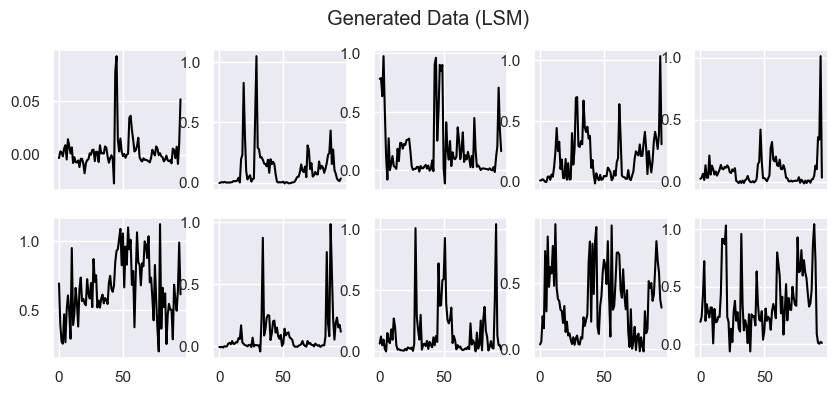

In [119]:
def plot_sample_grid(data, n_rows=2, n_cols=5, random_sample=True, title=None):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    sns.set()
    assert len(data) >= n_rows*n_cols

    # Reshape and take a sample.
    if data.dim() == 3:
        data = data.view(data.shape[0], data.shape[-1])

    if random_sample:
        rand_indices = np.random.choice(len(data), n_rows*n_cols)
        sample = data[rand_indices]
    else:
        sample = data[:n_rows*n_cols]

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2), sharex=True)
    count = 0
    for i in range(n_rows):
        for j in range(n_cols):
            axs[i, j].plot(sample[count], color='black')
            count += 1
    if title is not None:
        fig.suptitle(title)

plot_sample_grid(x_gen, title="Generated Data (LSM)")

In [120]:
list_assets = ['MAC000002', 'MAC000003', 'MAC000004', 'MAC000005', 'MAC000006', 'MAC000007', 'MAC000008',
               'MAC000009', 'MAC000010', 'MAC000011']
dm = LondonDataModule(assets=list_assets, window_length=48, overlap=46,
                      train_data_dir='train_data',
                      labels=False)

In [121]:
#dm.prepare_data() # For loading the dataset
dm.setup() # For loading data AND preparing train/validation set
dl = dm.train_dataloader()

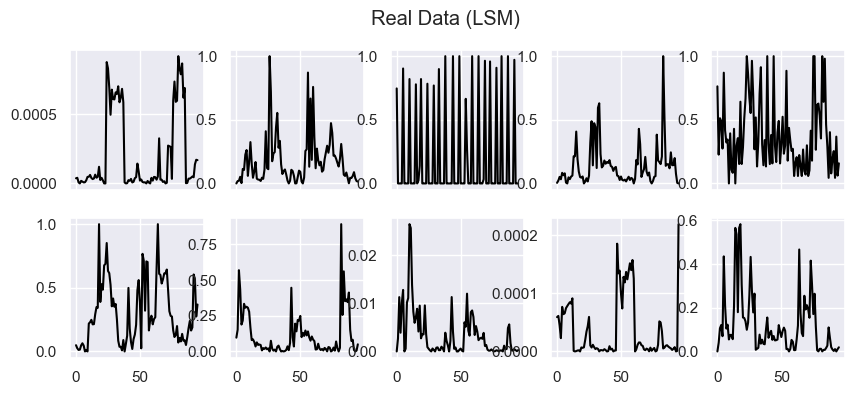

In [122]:
plot_sample_grid(dl.dataset[:], title="Real Data (LSM)")

In [100]:
idx = np.random.choice(len(dl.dataset), 5000)
realdata = dl.dataset[:][idx]

In [110]:
from sklearn.manifold import TSNE

#realdata = dl.dataset
X1 = realdata.numpy().reshape(realdata.shape[0], realdata.shape[-1])
X2 = x_gen.reshape(x_gen.shape[0], x_gen.shape[-1])
X = np.concatenate([X1, X2])
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50).fit_transform(X)

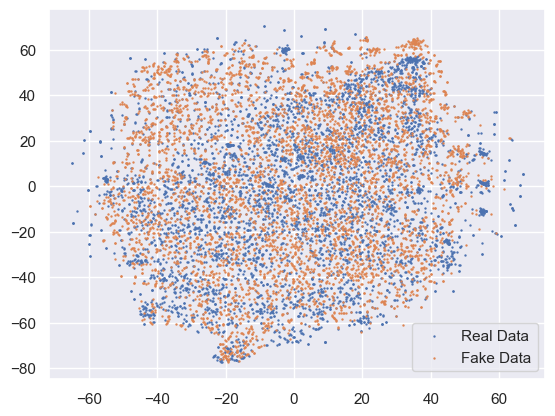

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure()
plt.scatter(X_embedded[:len(X1),0], X_embedded[:len(X1),1], marker='.', s=2, label="Real Data")
plt.scatter(X_embedded[len(X1):,0], X_embedded[len(X1):,1], marker='.', s=2, label="Fake Data")
plt.legend()
plt.show()

In [114]:
from syndatagenerators.metrics.mmd_score import mmd
mmd(realdata, x_gen)

tensor(0.0012, dtype=torch.float64)